# ML A/B Testing

## Imports

In [12]:
import scipy
import pickle
import warnings
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import Image
# from ABTesting import DfHelper


In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_helper import DfHelper

## Data reading

I have trained the models using mlflow. I have saved the final result.
Here we will load the test data and the models and explare the result and 
their implications to the overall goal.

In [4]:
helper = DfHelper()
test_features = helper.read_csv("../features/test_features.csv")
test_features.head(5)

2021-07-25 18:57:30,317 — DfHelper — DEBUG — file read as csv


,experiment,hour,date_of_week,date_of_month,device_make,platform_os,browser
0,1,0,4,10,10,1,1
1,1,21,3,9,0,1,0
2,0,15,4,3,0,1,0
3,1,3,2,8,0,1,0
4,1,20,3,9,0,1,0


In [5]:
test_labels = helper.read_csv("../features/test_labels.csv")
test_labels.head(5)

2021-07-25 18:57:32,805 — DfHelper — DEBUG — file read as csv


,aware
0,1
1,0
2,0
3,0
4,1


In [6]:
feature_columns = [f.replace('_', ' ').capitalize() for f in test_features]
feature_columns

['Experiment',
 'Hour',
 'Date of week',
 'Date of month',
 'Device make',
 'Platform os',
 'Browser']

In [7]:
def plot_feature_importance():
  plt.figure(figsize=(10, 6))
  ax = sns.barplot(x="Feature Importance", y=feat_imp.index, data=feat_imp)
  plt.ylabel('Feature', fontsize=14)
  plt.xlabel('Feature Importance', fontsize=14)
  plt.show()


In [15]:
def plot_confusion_metrics(actual, y_preds):
  plt.figure(figsize=(8, 6))
  cf_matrix = metrics.confusion_matrix(actual, y_preds)
  sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  plt.title('Confusion matrix', fontsize=15, fontweight='bold')
  plt.ylabel('Actual', fontsize=14)
  plt.xlabel('Predicted', fontsize=14)
  plt.show()


The problem we are trying to solve is a binary classification that predicts whether the users are aware of the brand. The target variable(y) is the classification of whether the user is aware of the brand. We will use three algorithms to get feature importances. Feature significance is what tells whether the experiment had some impact and also the contribution of other features.


## Logistic Regression

In [18]:
model = pickle.load(open("../models/logistic_model.pickle", "rb"))
model

LogisticRegression(random_state=42, solver='newton-cg')

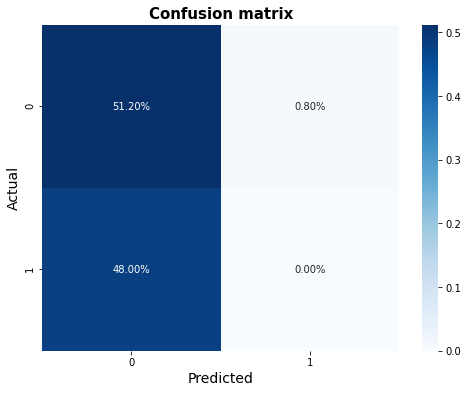

In [19]:
y_preds = model.predict(test_features)
plot_confusion_metrics(test_labels, y_preds)

In [20]:
feat_imp = pd.DataFrame({'Feature Importance': model.coef_[0]})
feat_imp['Feature'] = feature_columns
feat_imp = feat_imp.set_index('Feature')
feat_imp = feat_imp.sort_values(by=['Feature Importance'], ascending=False)
feat_imp

,Feature Importance
Feature,
Platform os,0.59
Experiment,0.05
Hour,0.02
Date of week,0.01
Date of month,0.01
Device make,0.00
Browser,-0.01


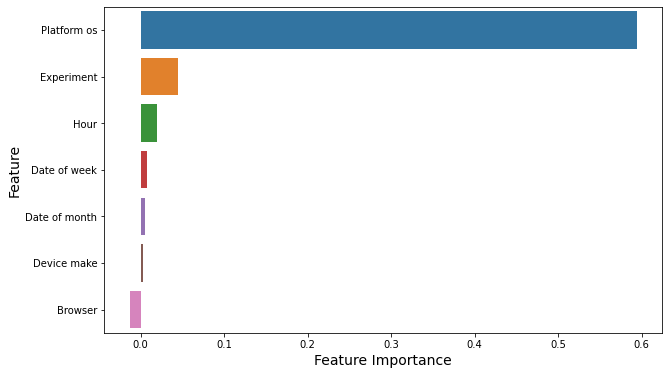

In [21]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Feature Importance", y=feat_imp.index, data=feat_imp)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Feature Importance', fontsize=14)
plt.show()

On the top, you see the feature importance of each feature on brand awareness. The longer the bar, the more important a feature. The most important feature by a big margin in determining brand awareness is Platform - os.


## Dicision Tree Classifier


In [34]:
model = pickle.load(open("../models/decision_tree_model.pickle", "rb"))
model

DecisionTreeClassifier(max_depth=2, random_state=42)

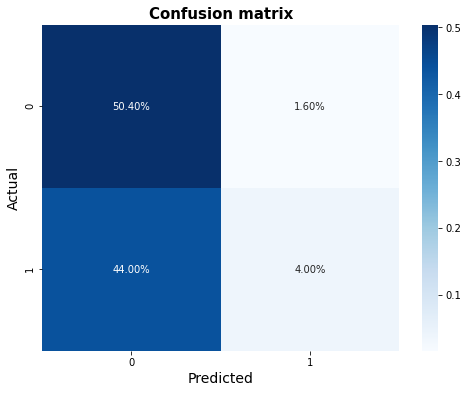

In [35]:
y_preds = model.predict(test_features)
plot_confusion_metrics(test_labels, y_preds)

In [36]:
feat_imp = pd.DataFrame({'Feature Importance': model.feature_importances_})
feat_imp['Feature'] = feature_columns
feat_imp = feat_imp.set_index('Feature')
feat_imp = feat_imp.sort_values(by=['Feature Importance'], ascending=False)
feat_imp

,Feature Importance
Feature,
Device make,0.43
Hour,0.35
Date of month,0.22
Experiment,0.00
Date of week,0.00
Platform os,0.00
Browser,0.00


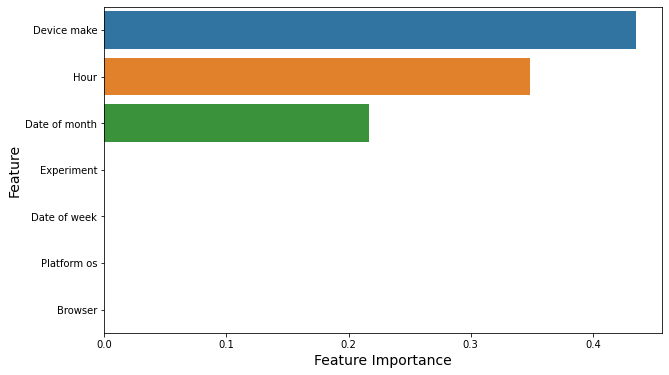

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Feature Importance", y=feat_imp.index, data=feat_imp)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Feature Importance', fontsize=14)
plt.show()


Here there are only 3 features that determining brand awareness. The device makes Hour and Date of Month. The experiment has no importance in determining brand awareness.


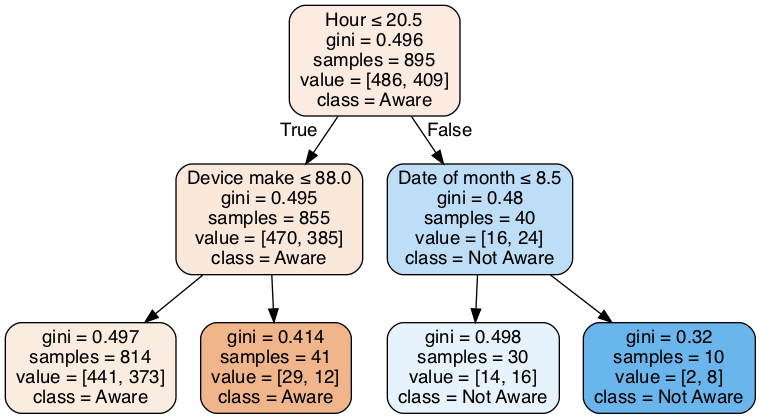

In [28]:
dot_data = tree.export_graphviz(
  model, 
  out_file="resume.dot",
  feature_names=feature_columns, 
  class_names=['Aware', 'Not Aware'],
  filled=True, 
  rounded=True, 
  special_characters=True, 
  leaves_parallel=False)
graph = pydotplus.graphviz.graph_from_dot_file("resume.dot")
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## XGBoost


In [29]:
model = pickle.load(open("../models/xgboost_model.pickle", "rb"))
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

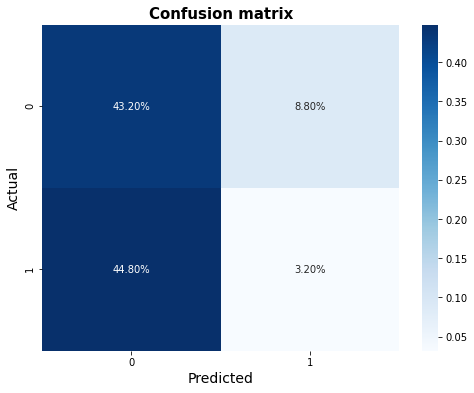

In [30]:
y_preds = model.predict(test_features)
plot_confusion_metrics(test_labels, y_preds)

In [31]:
feat_imp = pd.DataFrame({'Feature Importance': model.feature_importances_})
feat_imp['Feature'] = feature_columns
feat_imp = feat_imp.set_index('Feature')
feat_imp = feat_imp.sort_values(by=['Feature Importance'], ascending=False)
feat_imp

,Feature Importance
Feature,
Device make,0.20
Date of week,0.18
Date of month,0.17
Experiment,0.16
Hour,0.16
Browser,0.12
Platform os,0.00


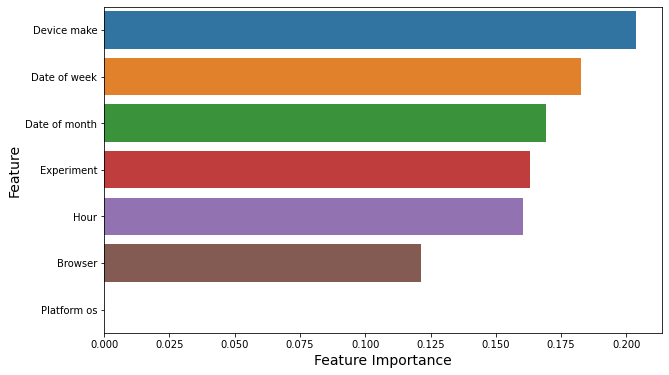

In [32]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Feature Importance", y=feat_imp.index, data=feat_imp)
plt.ylabel('Feature', fontsize=14)
plt.xlabel('Feature Importance', fontsize=14)
plt.show()


Here Experiment plays an almost similar role ass the rest of the features in determining brand awareness.
